# GfÖ 25 Machine Learning Demo

## Summary

This notebook demonstrates a complete workflow for geospatial machine learning using the Geo Engine platform. It covers preparation, raster and vector data loading, data fusion, model training with scikit-learn, ONNX model export, and application of the trained model to raster data. The workflow includes data upload, feature extraction, model evaluation, and saving prediction results as a new dataset.

**Sections:**

1. **Preparation**: Install dependencies, import libraries, set up credentials, and initialize the Geo Engine session.
2. **Raster Data**: Load Sentinel-2 raster data, convert bands, compute NDVI, and preview raster layers.
3. **Vector Data**: Load, merge, and upload point datasets for different classes (e.g., Trees and Non-Trees).
4. **Data Fusion**: Join vector points with raster features (bands and NDVI) to create a training dataset.
5. **Model Training**: Prepare features, train a Random Forest classifier, evaluate performance, and export the model to ONNX.
6. **Model Application**: Apply the trained ONNX model to raster data, visualize predictions, and save results as a new dataset.

## 1. Preparation

Uninstall and install the geoengine Python package from a specific GitHub commit.

In [ ]:
# %pip uninstall -y geoengine
# %pip install git+https://github.com/geo-engine/geoengine-python.git@9e0e5a649b6279da2e47613df814d8d4affaa6a2

Import required libraries for geospatial analysis and machine learning.

In [2]:
# Import necessary libraries
import geoengine as ge
import geoengine_openapi_client as geoc
from datetime import datetime
import pandas as pd

# For model training and evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType


Set credentials, workflow IDs, and configuration variables for the analysis.

In [ ]:
### ADD YOUR CREDENTIALS HERE ####

SESSION_TOKEN = "YOUR_SESSION_TOKEN_HERE"

### ADD THE WORKFLOW IDS FOR THE POINT LAYERS HERE ####
WORKFLOW_ID_CLASS_A = "YOUR_CLASS_A_WORKFLOW_HERE" # e.g., Trees
WORKFLOW_ID_CLASS_B = "YOUR_CLASS_B_WORKFLOW_HERE" # e.g., Non-Trees


### The following default settings are not required to be changed for the workshop ###

# Time interval for Sentinel-2 data, please keep it within one month to avoid too many data during the workshop
TIME_INTERVAL_TO_QUERY = ge.TimeInterval(datetime(2018, 7, 1), datetime(2018,8,1))

# Change this, if you want to create a new version of the dataset/model withlout deleting the old one
DATASET_SUFFIX = "v1"

# This is the dataset where all the input points are combined together
COMBINED_POINT_DATASET_NAME = "GfÖ 25 merged points " + DATASET_SUFFIX
COMBINED_POINT_DATASET_ID = COMBINED_POINT_DATASET_NAME.lower().replace(" ", "_").replace("ö", "oe")

# This is the name of the model that will be trained and used for prediction
TRAINED_MODEL_NAME = "GfÖ 25 RandomForest classifier " + DATASET_SUFFIX
TRAINED_MODEL_ID = TRAINED_MODEL_NAME.lower().replace(" ", "_").replace("ö", "oe").replace("ä", "ae")

# Final dataset name for the prediction results
PREDICTION_DATASET_NAME = "GfÖ 25 Predictions " + DATASET_SUFFIX
PREDICTION_DATASET_ID = PREDICTION_DATASET_NAME.lower().replace(" ", "_").replace("ö", "oe")

Initialize the geoengine session with the API URL and session token.

In [4]:
ge.initialize("https://vat.gfbio.org/api", token=SESSION_TOKEN)

Retrieve the current session and user ID.

In [5]:
session = ge.get_session()
user_id = session.user_id
session

Server:              https://vat.gfbio.org/api
User Id:             4bf110ff-ec6d-405d-a286-5087a4f5cf3d
Session Id:          ee0570bc-cfee-45b1-8005-f545179b4481
Session valid until: 2025-09-27T09:27:08.826Z

## 2. Raster data: Load the Sentinel-2 10m bands

The Sentinel-2 10m layer is part of the 'GfÖ Workshop' collection in the data catalog. First, load the root collection and then the 'GfÖ Workshop' project collection.

In [6]:
root_collection = ge.layer_collection()
root_of_data_catalog = root_collection.items[0].load()
project_collection = root_of_data_catalog.get_items_by_name("GfÖ Workshop")[0].load()
display(project_collection)


Layer Collection
name: GfÖ Workshop
description: Prepared Layers for participants of the GfÖ Workshop (2025)
id: ea1f9b39-07e6-44c6-89b6-46c0736f5665
provider id: ce5e84db-cbf9-48a2-9a32-d4b7cc56ea74
items: Layer
name: NDVI
description: NDVI computed from monthly aggregate of 10m resolution RGB stacked, cloud free Sentinel-2 data for 2018
id: 8d83d5af-8805-4f81-8cd8-ed571a621f93
provider id: ce5e84db-cbf9-48a2-9a32-d4b7cc56ea74

       Layer
name: Non-tree locations
description: Sample non-tree location labels
id: 885829ce-079f-4a09-8d9a-acfbc6cd8497
provider id: ce5e84db-cbf9-48a2-9a32-d4b7cc56ea74

       Layer
name: Sentinel-2
description: 10m resolution RGB stacked, cloud free Sentinel-2 data for 2018
id: 12405f8a-8b67-41fa-b5d4-bd9aa844900e
provider id: ce5e84db-cbf9-48a2-9a32-d4b7cc56ea74

       Layer
name: Sentinel-2 Monthly Aggregate
description: Colorized monthly aggregate of 10m resolution RGB stacked, cloud free Sentinel-2 data for 2018
id: 37a02ee9-3b94-410a-a022-64e54c49995a
provider id: ce5e84db-cbf9-48a2-9a32-d4b7cc56ea74

       Layer
name: Tree locations
description: Sample tree location labels
id: cc537aa6-80d3-43c6-adf7-f983ac19e7ce
provider id: ce5e84db-cbf9-48a2-9a32-d4b7cc56ea74

Load and display the Sentinel-2 Monthly Aggregate bands layer from the collection.
A layer has a name, a description and a `Workflow` that defines how the data, the layer represents, is processed.

In [7]:
s2_monthly_bands = project_collection.get_items_by_name("Sentinel-2 Monthly Aggregate")[0].load()
display(s2_monthly_bands)

Layer
name: Sentinel-2 Monthly Aggregate
description: Colorized monthly aggregate of 10m resolution RGB stacked, cloud free Sentinel-2 data for 2018
id: 37a02ee9-3b94-410a-a022-64e54c49995a
provider id: ce5e84db-cbf9-48a2-9a32-d4b7cc56ea74
workflow: {'operator': {'params': {'aggregation': {'type': 'mean', 'ignoreNoData': True}, 'window': {'granularity': 'months', 'step': 1}, 'windowReference': None, 'outputType': None}, 'sources': {'raster': {'type': 'RasterStacker', 'params': {'renameBands': {'type': 'rename', 'values': ['B02', 'B03', 'B04', 'B08']}}, 'sources': {'rasters': [{'type': 'Expression', 'params': {'expression': 'if (B == 3 || (B >= 7 && B <= 11)) { NODATA } else { A }', 'outputType': 'U16', 'outputBand': None, 'mapNoData': False}, 'sources': {'raster': {'type': 'RasterStacker', 'params': {'renameBands': {'type': 'default'}}, 'sources': {'rasters': [{'type': 'GdalSource', 'params': {'data': 'S2M_mosaic_zone_32N_band_B02'}}, {'type': 'GdalSource', 'params': {'data': 'S2M_mosaic_zone_32N_band_SCL'}}]}}}}, {'type': 'Expression', 'params': {'expression': 'if (B == 3 || (B >= 7 && B <= 11)) { NODATA } else { A }', 'outputType': 'U16', 'outputBand': None, 'mapNoData': False}, 'sources': {'raster': {'type': 'RasterStacker', 'params': {'renameBands': {'type': 'default'}}, 'sources': {'rasters': [{'type': 'GdalSource', 'params': {'data': 'S2M_mosaic_zone_32N_band_B03'}}, {'type': 'GdalSource', 'params': {'data': 'S2M_mosaic_zone_32N_band_SCL'}}]}}}}, {'type': 'Expression', 'params': {'expression': 'if (B == 3 || (B >= 7 && B <= 11)) { NODATA } else { A }', 'outputType': 'U16', 'outputBand': None, 'mapNoData': False}, 'sources': {'raster': {'type': 'RasterStacker', 'params': {'renameBands': {'type': 'default'}}, 'sources': {'rasters': [{'type': 'GdalSource', 'params': {'data': 'S2M_mosaic_zone_32N_band_B04'}}, {'type': 'GdalSource', 'params': {'data': 'S2M_mosaic_zone_32N_band_SCL'}}]}}}}, {'type': 'Expression', 'params': {'expression': 'if (B == 3 || (B >= 7 && B <= 11)) { NODATA } else { A }', 'outputType': 'U16', 'outputBand': None, 'mapNoData': False}, 'sources': {'raster': {'type': 'RasterStacker', 'params': {'renameBands': {'type': 'default'}}, 'sources': {'rasters': [{'type': 'GdalSource', 'params': {'data': 'S2M_mosaic_zone_32N_band_B08'}}, {'type': 'GdalSource', 'params': {'data': 'S2M_mosaic_zone_32N_band_SCL'}}]}}}}]}}}, 'type': 'TemporalRasterAggregation'}, 'type': 'Raster'}
symbology: <class 'geoengine.types.RasterSymbology'>(MultiBandRasterColorizer(blue_band=0, blue_max=4000.0, blue_min=0.0, blue_scale=1.0, green_band=1, green_max=4000.0, green_min=0.0, green_scale=1.0, red_band=2, red_max=4000.0, red_min=0.0, red_scale=1.0), 10000.0)
properties: []
metadata: {}

The Geo Engine package uses the `Workflow` type to represent data processing graphs. Convert the Sentinel-2 bands collection to a workflow.

In [8]:
s2_monthly_workflow = s2_monthly_bands.as_workflow()

A `Workflow` can describe the data it produces. This is called `ResultDescriptor` in Geo Engine. For the Sentinel-2 monthly bands it contains the data type, the sptial reference system and the bands.

In [9]:
s2_monthly_result_descriptor = s2_monthly_workflow.get_result_descriptor()
s2_monthly_result_descriptor

Data type:         U16
Spatial Reference: EPSG:4326
Bands:
    B02: unitless
    B03: unitless
    B04: unitless
    B08: unitless

A `Workflow` represents how the Geo Engine processes data. To query data from the Geo Engine, a `QueryRectangle` is required.
For a preview of the Sentinel-2 data, we use the spatial bounds provided by the `ResultDescriptor` with a lower resolution.
Additionally, we request the time of interest defined at top of the notebook.

In [10]:
preview_query_rectangle = ge.QueryRectangle(
    s2_monthly_workflow.get_result_descriptor().spatial_bounds.to_bounding_box(), # get the bounds from the ResultDescriptor
    TIME_INTERVAL_TO_QUERY,
    ge.SpatialResolution(s2_monthly_result_descriptor.spatial_resolution.x_resolution*10, s2_monthly_result_descriptor.spatial_resolution.y_resolution*10),
    srs="EPSG:4326",
    )
preview_query_rectangle

QueryRectangle( 
    BoundingBox2D(xmin=7.560547850100084, ymin=50.45520577342848, xmax=9.140508522607764, ymax=51.4511821925227)
    TimeInterval(start=2018-07-01T00:00:00.000000, end=2018-08-01T00:00:00.000000)
    SpatialResolution(x=0.0011952195116935313, y=0.0011952195116935313)
    srs=EPSG:4326 
)

To load Sentinel-2 monthly data as an xarray for the preview area, the `Workflow` is queried using the defined `QueryRectangle`. Using the `.raster_stream_into_xarray()` method, the result is directly available as `Xarray.DataArray`.

In [11]:
s2_monthly_arr = await s2_monthly_workflow.raster_stream_into_xarray(preview_query_rectangle, bands=[0,1,2])
s2_monthly_arr

<xarray.DataArray (time: 1, band: 3, y: 1536, x: 1536)> Size: 28MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]],
      shape=(1, 3, 1536, 1536), dtype=float32)
Coordinates:
  * x            (x) float64 12kB 7.344 7.345 7.346 7.348 ... 9.176 9.177 9.179
  * y            (y) float64 12kB 52.02 52.01 52.01 52.01 ... 50.18 50.18 50.18
  * time         (time) datetime64[ns] 8B 2018-07-01
  * band         (band) int64 24B 0 1 2
    spatial_ref  int64 8B 0

Plot an RGB image from the Sentinel-2 monthly data.

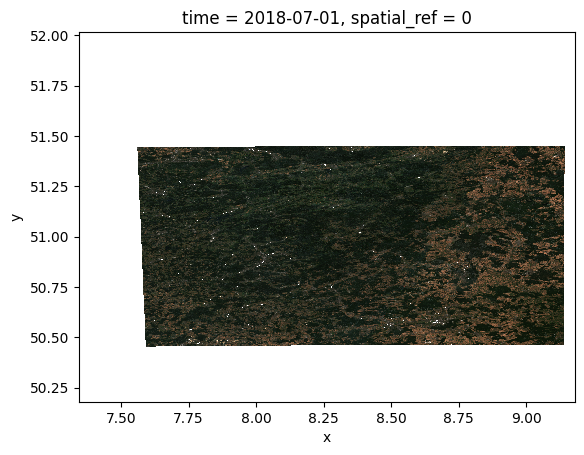

In [12]:
s2_monthly_arr.isel(time=0,band=[2,1,0]).plot.imshow(vmin=0, vmax=4000)

A `Workflow`is composed of `Operator`s. Using the `RasterTypeConversion` we can convert the Sentinel-2 bands to the float32 data type.

In [13]:
s2_monthly_bands_operator = ge.workflow_builder.operators.RasterOperator.from_workflow_dict(s2_monthly_bands.workflow)
s2_monthly_bands_operator_f32 = ge.workflow_builder.operators.RasterTypeConversion(source=s2_monthly_bands_operator, output_data_type='F32')
s2_monthly_bands_operator_f32

After registering the float32-converted Sentinel-2 bands workflow, the `ResultDescriptor` shows the changed data type.

In [14]:
ge.register_workflow(s2_monthly_bands_operator_f32).get_result_descriptor()

Data type:         F32
Spatial Reference: EPSG:4326
Bands:
    B02: unitless
    B03: unitless
    B04: unitless
    B08: unitless

Using the `Expression` Operator we can calculate the Normalized Difference Vegetation Index, which is a widely used indicator for vegetation health. It is calculated from the red and near-infrared bands of multispectral imagery using the formula: NDVI = (NIR - Red) / (NIR + Red). Higher NDVI values indicate denser and healthier vegetation, while lower values correspond to sparse or non-vegetated areas.

In [15]:
s2_monthly_ndvi_operator = ge.workflow_builder.operators.Expression(expression="(D-C)/(C+D)", map_no_data=False, source=s2_monthly_bands_operator_f32, output_type='F32', output_band=ge.RasterBandDescriptor("NDVI", ge.UnitlessMeasurement()))
s2_monthly_ndvi_operator

Register the NDVI workflow and get its result descriptor.

In [16]:
ge.register_workflow(s2_monthly_ndvi_operator).get_result_descriptor()

Data type:         F32
Spatial Reference: EPSG:4326
Bands:
    NDVI: unitless

The `RasterStacker` combines multiple raster workflows into one. Stacking the Sentinel-2 bands and NDVI into a single workflow, allows to combine all bands in a single step with the label points.

In [17]:
s2_monthly_bands_with_ndvi_operator = ge.workflow_builder.operators.RasterStacker(sources=[s2_monthly_bands_operator_f32, s2_monthly_ndvi_operator])
s2_monthly_bands_with_ndvi_operator

Register the stacked bands and NDVI workflow and get its `ResultDescriptor`. The `ResultDescriptor` shows the 10m bands and the NDVI as bands.

In [18]:
s2_bands_with_ndvi_workflow = ge.register_workflow(s2_monthly_bands_with_ndvi_operator)
s2_bands_with_ndvi_workflow.get_result_descriptor()

Data type:         F32
Spatial Reference: EPSG:4326
Bands:
    B02: unitless
    B03: unitless
    B04: unitless
    B08: unitless
    NDVI: unitless

Load the stacked bands and NDVI as an xarray for the preview area.

In [19]:
s2_bands_with_ndvi_workflow_arr = await s2_bands_with_ndvi_workflow.raster_stream_into_xarray(preview_query_rectangle, bands=[0,1,2,3,4])
s2_bands_with_ndvi_workflow_arr

<xarray.DataArray (time: 1, band: 5, y: 1536, x: 1536)> Size: 47MB
array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]]]],
      shape=(1, 5, 1536, 1536), dtype=float32)
Coordinates:
  * x            (x) float64 12kB 7.344 7.345 7.346 7.348 ... 9.176 9.177 9.179
  * y            (y) float64 12kB 52.02 52.01 52.01 52.01 ... 50.18 50.18 50.18
  * time         (time) datetime64[ns] 8B 2018-07-01
  * band         (band) int64 40B 0 1 2 3 4
    spatial_ref  int64 8B 0

Plot all bands and NDVI from the stacked xarray. Since the NDVI has a very different value range, we display it as addtional plot...

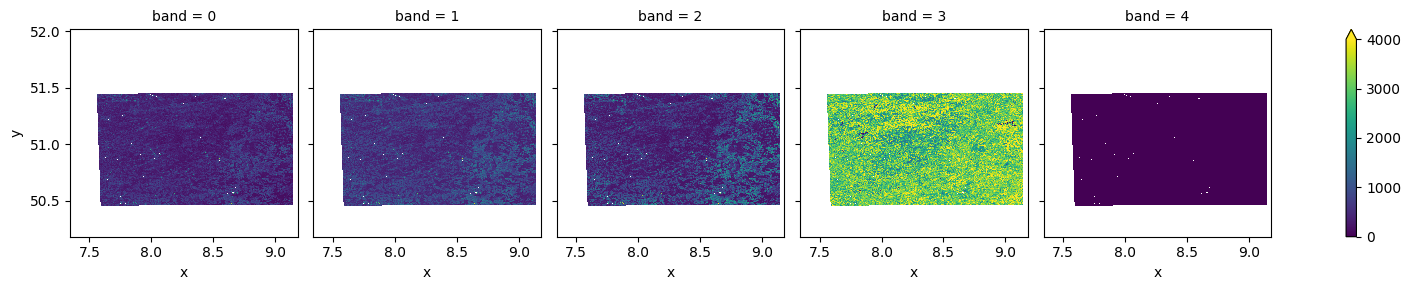

In [20]:
s2_bands_with_ndvi_workflow_arr.isel(time=0,band=[0,1,2,3,4]).plot.imshow(vmin=-1, vmax=4000, col="band") 

Plot only the NDVI band from the stacked xarray.

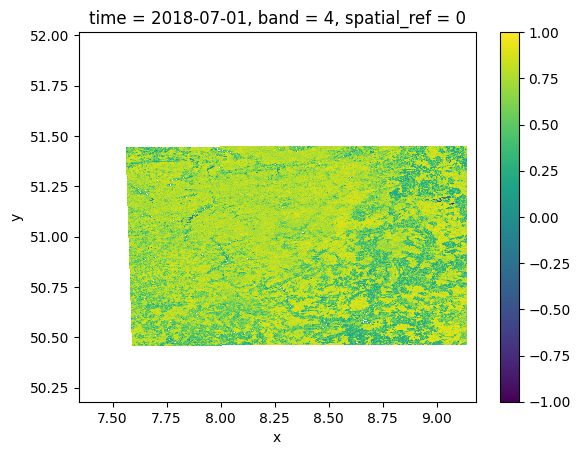

In [21]:
s2_bands_with_ndvi_workflow_arr.isel(time=0,band=[4]).plot(vmin=-1, vmax=1) # TODO: should select band 0 if only one selected

## 3. Vector data: Load the label point data and perform data preparation.

Load the workflow for class A (Trees) points and get its result descriptor.

In [22]:
workflow_class_a = ge.workflow_by_id(WORKFLOW_ID_CLASS_A)
workflow_class_a.get_result_descriptor()

Data type:         MultiPoint
Spatial Reference: EPSG:4326
Columns:
  id:
    Column Type: int
    Measurement: unitless

Load class A (Trees) points as a GeoDataFrame.

In [23]:
workflow_class_a_df = await workflow_class_a.vector_stream_into_geopandas(preview_query_rectangle)
workflow_class_a_df

,id,geometry,time_start,time_end
0,1,MULTIPOINT ((8.75781 50.75904)),NaT,NaT
1,2,MULTIPOINT ((8.7594 50.75952)),NaT,NaT
2,3,MULTIPOINT ((8.75753 50.76059)),NaT,NaT
3,4,MULTIPOINT ((8.75763 50.76254)),NaT,NaT
4,5,MULTIPOINT ((8.76116 50.76287)),NaT,NaT
...,...,...,...,...
257,258,MULTIPOINT ((8.6996 50.77209)),NaT,NaT
258,259,MULTIPOINT ((8.70043 50.77133)),NaT,NaT
259,260,MULTIPOINT ((8.70069 50.76984)),NaT,NaT
260,261,MULTIPOINT ((8.69898 50.76908)),NaT,NaT


Plot the class A (Trees) points.

<Axes: >

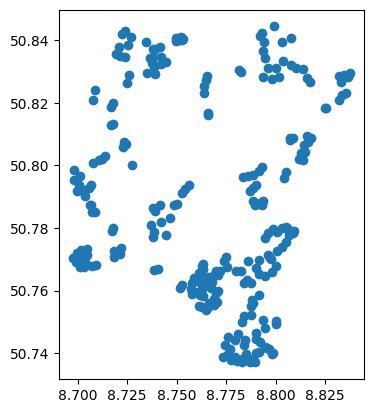

In [24]:
workflow_class_a_df.plot()

Load the workflow for class B (Non-Trees) points.

In [25]:
workflow_class_b = ge.workflow_by_id(WORKFLOW_ID_CLASS_B)
workflow_class_b

7216fca0-9d58-5162-bcf3-f4699fbc9609

Load class B (Non-Trees) points as a GeoDataFrame.

In [26]:
workflow_class_b_df = await workflow_class_b.vector_stream_into_geopandas(preview_query_rectangle)
workflow_class_b_df

,id,geometry,time_start,time_end
0,1,MULTIPOINT ((8.80987 50.86016)),NaT,NaT
1,2,MULTIPOINT ((8.80829 50.86038)),NaT,NaT
2,3,MULTIPOINT ((8.81332 50.86197)),NaT,NaT
3,4,MULTIPOINT ((8.80892 50.863)),NaT,NaT
4,5,MULTIPOINT ((8.80828 50.86339)),NaT,NaT
...,...,...,...,...
788,789,MULTIPOINT ((8.73239 50.7342)),NaT,NaT
789,790,MULTIPOINT ((8.73392 50.73538)),NaT,NaT
790,791,MULTIPOINT ((8.7315 50.73579)),NaT,NaT
791,792,MULTIPOINT ((8.73285 50.73661)),NaT,NaT


Plot the class B (Non-Trees) points.

<Axes: >

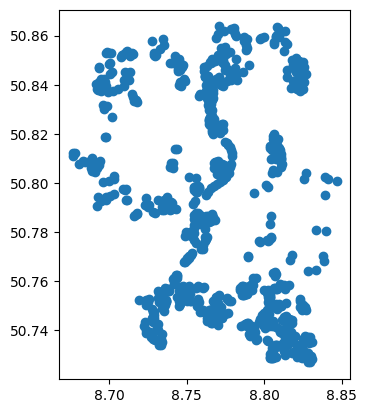

In [27]:
workflow_class_b_df.plot()

Assign class labels and merge class A and B points into a single DataFrame.

In [28]:
workflow_class_a_df = workflow_class_a_df.assign(cls=0)
workflow_class_b_df = workflow_class_b_df.assign(cls=1)

merged_points_df = pd.concat([workflow_class_a_df, workflow_class_b_df], ignore_index=True)
merged_points_df

,id,geometry,time_start,time_end,cls
0,1,MULTIPOINT ((8.75781 50.75904)),NaT,NaT,0
1,2,MULTIPOINT ((8.7594 50.75952)),NaT,NaT,0
2,3,MULTIPOINT ((8.75753 50.76059)),NaT,NaT,0
3,4,MULTIPOINT ((8.75763 50.76254)),NaT,NaT,0
4,5,MULTIPOINT ((8.76116 50.76287)),NaT,NaT,0
...,...,...,...,...,...
1050,789,MULTIPOINT ((8.73239 50.7342)),NaT,NaT,1
1051,790,MULTIPOINT ((8.73392 50.73538)),NaT,NaT,1
1052,791,MULTIPOINT ((8.7315 50.73579)),NaT,NaT,1
1053,792,MULTIPOINT ((8.73285 50.73661)),NaT,NaT,1


Add time interval columns to the merged points DataFrame.

In [29]:
TIME_FORMAT = "%Y-%m-%dT%H:%M:%S"
merged_points_df["time_start"] = TIME_INTERVAL_TO_QUERY.start
merged_points_df["time_end"] = TIME_INTERVAL_TO_QUERY.end
merged_points_df["time_start"] = merged_points_df["time_start"].dt.strftime("%Y-%m-%dT%H:%M:%S")
merged_points_df["time_end"] = merged_points_df["time_end"].dt.strftime("%Y-%m-%dT%H:%M:%S")
merged_points_df

,id,geometry,time_start,time_end,cls
0,1,MULTIPOINT ((8.75781 50.75904)),2018-07-01T00:00:00,2018-08-01T00:00:00,0
1,2,MULTIPOINT ((8.7594 50.75952)),2018-07-01T00:00:00,2018-08-01T00:00:00,0
2,3,MULTIPOINT ((8.75753 50.76059)),2018-07-01T00:00:00,2018-08-01T00:00:00,0
3,4,MULTIPOINT ((8.75763 50.76254)),2018-07-01T00:00:00,2018-08-01T00:00:00,0
4,5,MULTIPOINT ((8.76116 50.76287)),2018-07-01T00:00:00,2018-08-01T00:00:00,0
...,...,...,...,...,...
1050,789,MULTIPOINT ((8.73239 50.7342)),2018-07-01T00:00:00,2018-08-01T00:00:00,1
1051,790,MULTIPOINT ((8.73392 50.73538)),2018-07-01T00:00:00,2018-08-01T00:00:00,1
1052,791,MULTIPOINT ((8.7315 50.73579)),2018-07-01T00:00:00,2018-08-01T00:00:00,1
1053,792,MULTIPOINT ((8.73285 50.73661)),2018-07-01T00:00:00,2018-08-01T00:00:00,1


It is also possible to upload a `DataFrame` into the Geo Enigne using the `upload_dataframe()` method. Here, we upload the merged points DataFrame as a new dataset to geoengine. The dataset is now also available in the UI (Personal Data Catalog -> User Uploads)!

In [30]:
upload_vector_data_to_ge_dataset = ge.upload_dataframe(
    df=merged_points_df,
    name=f"{session.user_id}:{COMBINED_POINT_DATASET_ID}",
    display_name=COMBINED_POINT_DATASET_NAME,
    time=ge.OgrSourceDatasetTimeType.start_end(
        start_field="time_start",
        start_format=ge.OgrSourceTimeFormat.auto(),
          end_field="time_end",
          end_format=ge.OgrSourceTimeFormat.auto())
          )
upload_vector_data_to_ge_dataset

4bf110ff-ec6d-405d-a286-5087a4f5cf3d:gfoe_25_merged_points_v7

## 4. Data Fusion: Combine the raster and vector data to generate training data for ML

Join the uploaded points with the raster bands and NDVI. First, loading a dataset requires either a `Workflow` or a source operator like the `OgrSource`. Then, the `RasterVectorJoin`operator can attach the raster values for each point from the provided raster workflows. Here, we use the Sentinel-2 bands and the NDVI.

In [31]:
operator_classes = ge.workflow_builder.operators.OgrSource(upload_vector_data_to_ge_dataset)
operator_classes_with_bands = ge.workflow_builder.operators.RasterVectorJoin(raster_sources=[s2_monthly_bands_with_ndvi_operator], vector_source=operator_classes, names=ge.workflow_builder.operators.ColumnNamesDefault())
operator_classes_with_bands

Register the workflow that joins points with raster bands and NDVI. The `ResultDesciptor` of the vector data now shows the bands as attributes.

In [32]:
operator_classes_with_bands_workflow = ge.register_workflow(operator_classes_with_bands)
operator_classes_with_bands_workflow.get_result_descriptor()

Data type:         MultiPoint
Spatial Reference: EPSG:4326
Columns:
  B04:
    Column Type: float
    Measurement: unitless
  B03:
    Column Type: float
    Measurement: unitless
  id:
    Column Type: int
    Measurement: unitless
  cls:
    Column Type: int
    Measurement: unitless
  time_start:
    Column Type: text
    Measurement: unitless
  B08:
    Column Type: float
    Measurement: unitless
  B02:
    Column Type: float
    Measurement: unitless
  NDVI:
    Column Type: float
    Measurement: unitless
  time_end:
    Column Type: text
    Measurement: unitless

Define a query rectangle based on the bounding box of the merged points.

In [33]:
query_rectangle = ge.QueryRectangle(
    ge.BoundingBox2D(*merged_points_df.total_bounds), # use the bbox of the points
    TIME_INTERVAL_TO_QUERY,
    ge.SpatialResolution(s2_monthly_result_descriptor.spatial_resolution.x_resolution, s2_monthly_result_descriptor.spatial_resolution.y_resolution),
    srs="EPSG:4326")

Load the joined points and raster bands as a GeoDataFrame.

In [34]:
operator_class_a_with_bands_df = await operator_classes_with_bands_workflow.vector_stream_into_geopandas(query_rectangle)
operator_class_a_with_bands_df

,time_start,time_end,id,cls,B02,B03,B04,B08,NDVI,geometry
0,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,1,0,354.0,575.0,375.0,4011.0,0.829001,MULTIPOINT ((8.75781 50.75904))
1,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,2,0,269.0,351.0,249.0,2518.0,0.820022,MULTIPOINT ((8.7594 50.75952))
2,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,3,0,329.0,458.0,326.0,3760.0,0.840431,MULTIPOINT ((8.75753 50.76059))
3,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,4,0,359.0,499.0,343.0,4490.0,0.858059,MULTIPOINT ((8.75763 50.76254))
4,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,5,0,299.0,419.0,280.0,3488.0,0.851380,MULTIPOINT ((8.76116 50.76287))
...,...,...,...,...,...,...,...,...,...,...
1050,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,789,1,982.0,1346.0,1909.0,2835.0,0.195194,MULTIPOINT ((8.73239 50.7342))
1051,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,790,1,775.0,1090.0,1331.0,3055.0,0.393069,MULTIPOINT ((8.73392 50.73538))
1052,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,791,1,688.0,974.0,1233.0,2697.0,0.372519,MULTIPOINT ((8.7315 50.73579))
1053,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,792,1,616.0,895.0,1004.0,3030.0,0.502231,MULTIPOINT ((8.73285 50.73661))


Remove rows with missing values from the training data.

In [35]:
training_points_no_na_df = operator_class_a_with_bands_df.dropna()
training_points_no_na_df

,time_start,time_end,id,cls,B02,B03,B04,B08,NDVI,geometry
0,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,1,0,354.0,575.0,375.0,4011.0,0.829001,MULTIPOINT ((8.75781 50.75904))
1,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,2,0,269.0,351.0,249.0,2518.0,0.820022,MULTIPOINT ((8.7594 50.75952))
2,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,3,0,329.0,458.0,326.0,3760.0,0.840431,MULTIPOINT ((8.75753 50.76059))
3,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,4,0,359.0,499.0,343.0,4490.0,0.858059,MULTIPOINT ((8.75763 50.76254))
4,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,5,0,299.0,419.0,280.0,3488.0,0.851380,MULTIPOINT ((8.76116 50.76287))
...,...,...,...,...,...,...,...,...,...,...
1050,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,789,1,982.0,1346.0,1909.0,2835.0,0.195194,MULTIPOINT ((8.73239 50.7342))
1051,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,790,1,775.0,1090.0,1331.0,3055.0,0.393069,MULTIPOINT ((8.73392 50.73538))
1052,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,791,1,688.0,974.0,1233.0,2697.0,0.372519,MULTIPOINT ((8.7315 50.73579))
1053,2018-07-01 00:00:00+00:00,2018-08-01 00:00:00+00:00,792,1,616.0,895.0,1004.0,3030.0,0.502231,MULTIPOINT ((8.73285 50.73661))


## 5. Model Training: Training a ML model using the point labels with raster values.

Select features and labels for model training from the point data frame.

In [36]:
X = training_points_no_na_df[["B02", "B03", "B04","B08","NDVI"]]
y = training_points_no_na_df["cls"]

Plot histograms of the feature columns.

array([[<Axes: title={'center': 'B02'}>, <Axes: title={'center': 'B03'}>],
       [<Axes: title={'center': 'B04'}>, <Axes: title={'center': 'B08'}>],
       [<Axes: title={'center': 'NDVI'}>, <Axes: >]], dtype=object)

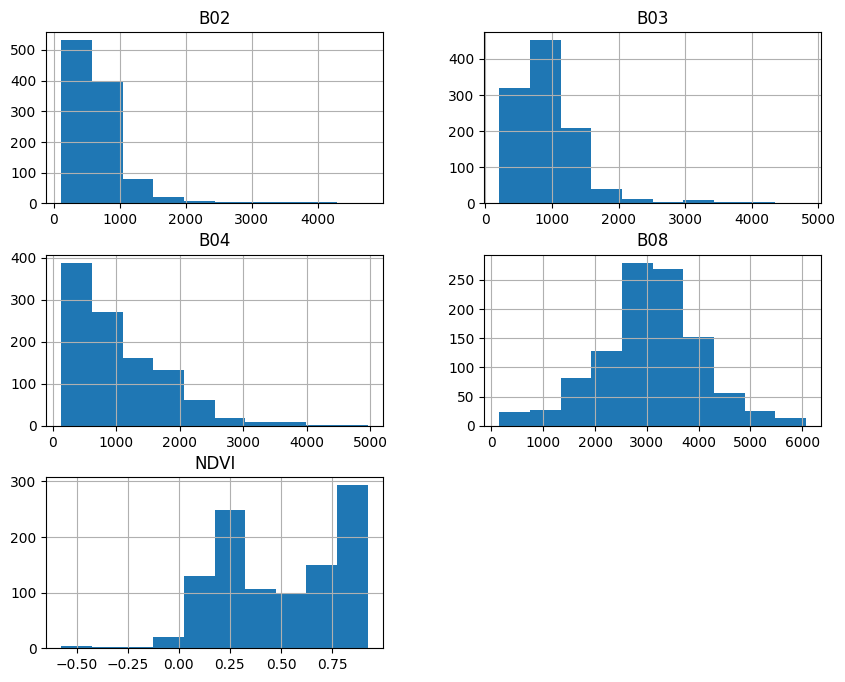

In [ ]:
X.hist(figsize=(10,8))

Split the data into training and test sets. Here, we use 20% for the test set.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train: {len(X_train)} points")
print(f"X_test: {len(X_test)} points")

X_train: 844 points
X_test: 211 points


Train a Random Forest classifier on the training data.

In [39]:
clf_rf = RandomForestClassifier(random_state=42).fit(X_train, y_train)
clf_rf

RandomForestClassifier(random_state=42)

Print a classification report for the trained model.

In [40]:
print(classification_report(y_test, clf_rf.predict(X_test), target_names=["Class A (Trees)", "Class B (Non-Trees)"], zero_division=0))

                     precision    recall  f1-score   support

    Class A (Trees)       0.96      0.93      0.94        55
Class B (Non-Trees)       0.97      0.99      0.98       156

           accuracy                           0.97       211
          macro avg       0.97      0.96      0.96       211
       weighted avg       0.97      0.97      0.97       211



## 6. Model Application: Transfer the trained model to the Geo Enigne and apply it to the Sentinel-2 data

Convert the trained Random Forest model to ONNX format.

In [41]:
initial_type=[('X', FloatTensorType([None, X_train.shape[1]]))]
onx = convert_sklearn(clf_rf, initial_types=initial_type)

Register the ONNX model in geoengine with metadata and configuration.

In [42]:
model_name = f"{ge.get_session().user_id}:{TRAINED_MODEL_ID}"


metadata = ge.ml.MlModelMetadata(
    file_name=f"{TRAINED_MODEL_ID}.onnx",
    input_type=geoc.models.RasterDataType.F32,
    num_input_bands=X_train.shape[1], # number of inputs
    output_type=geoc.models.RasterDataType.I64,
)

model_config = ge.ml.MlModelConfig(
    name=model_name,
    metadata=metadata,
    display_name=TRAINED_MODEL_NAME,
    description="A model trained at the GfÖ 25 VAT workshop",
)

ge.register_ml_model(onnx_model=onx, model_config=model_config)

4bf110ff-ec6d-405d-a286-5087a4f5cf3d:gfoe_25_randomforest_classifier_v7

Create a workflow for ONNX model inference on raster data.

In [43]:
onnx_workflow = ge.workflow_builder.operators.Onnx(source=s2_monthly_bands_with_ndvi_operator, model=model_name)
onnx_workflow = ge.workflow_builder.operators.RasterTypeConversion(source=onnx_workflow, output_data_type='U16')
onnx_workflow

Register the ONNX inference workflow and get its result descriptor.

In [44]:
onnx_registered_workflow = ge.register_workflow(onnx_workflow)
onnx_registered_workflow.get_result_descriptor()

Data type:         U16
Spatial Reference: EPSG:4326
Bands:
    prediction: unitless

Run the ONNX model on the raster data and load predictions as an xarray.

In [45]:
onnx_prediction_arr = await onnx_registered_workflow.raster_stream_into_xarray(query_rectangle, bands=[0])
onnx_prediction_arr

<xarray.DataArray (time: 1, band: 1, y: 2048, x: 2048)> Size: 8MB
array([[[[1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         [1, 1, 1, ..., 1, 1, 1],
         ...,
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1],
         [0, 0, 0, ..., 1, 1, 1]]]],
      shape=(1, 1, 2048, 2048), dtype=uint16)
Coordinates:
  * x            (x) float64 16kB 8.629 8.629 8.629 8.629 ... 8.873 8.873 8.873
  * y            (y) float64 16kB 50.91 50.91 50.91 50.91 ... 50.67 50.67 50.67
  * time         (time) datetime64[ns] 8B 2018-07-01
  * band         (band) int64 8B 0
    spatial_ref  int64 8B 0

Plot the ONNX model prediction results.

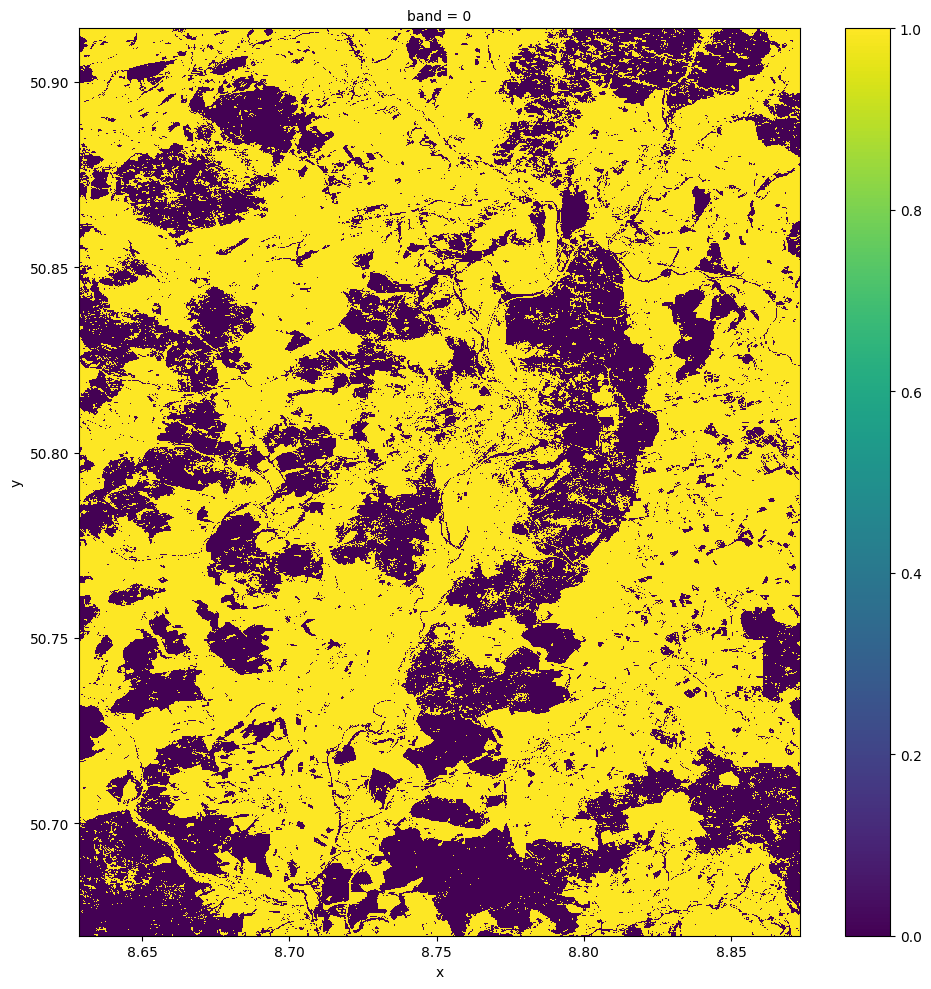

In [46]:
onnx_prediction_arr.isel(time=0).plot.imshow(col="band", vmin=0, vmax=1, figsize=(10,10))

Save the ONNX model prediction results as a new dataset in geoengine.

In [47]:
res = await onnx_registered_workflow.save_as_dataset(query_rectangle.as_raster_query_rectangle_api_dict(), name=f"{user_id}:{PREDICTION_DATASET_ID}", display_name=PREDICTION_DATASET_NAME).as_future(print_status=True)
res

TimeInterval(start=2018-07-01T00:00:00.000000, end=2018-08-01T00:00:00.000000) 1530403200000 1533081600000
status=running, time_started=2025-08-29 16:07:14.853000+00:00, pct_complete=0.00%, estimated_time_remaining=? (± ?), info=None, task_type=create-dataset, description=Creating dataset GfÖ 25 Predictions v7 from workflow fdc09790-1280-5780-8b04-5f28b3851aed
status=completed, time_started=2025-08-29 16:07:14.853000+00:00, info={'dataset': '4bf110ff-ec6d-405d-a286-5087a4f5cf3d:gfoe_25_predictions_v7', 'upload': 'b205bd2d-5651-4e01-841e-99ce9bd475cb'}, time_total=00:00:01, task_type=create-dataset, description=Creating dataset GfÖ 25 Predictions v7 from workflow fdc09790-1280-5780-8b04-5f28b3851aed


TaskStatusInfo(status='completed', time_started=datetime.datetime(2025, 8, 29, 16, 7, 14, 853000, tzinfo=datetime.timezone.utc), info = {'dataset': '4bf110ff-ec6d-405d-a286-5087a4f5cf3d:gfoe_25_predictions_v7', 'upload': 'b205bd2d-5651-4e01-841e-99ce9bd475cb'}, time_total = '00:00:01', task_type='create-dataset', description='Creating dataset GfÖ 25 Predictions v7 from workflow fdc09790-1280-5780-8b04-5f28b3851aed')